# Data Understanding

The development data is split into 7 files, each with some table of a relational model. Let's start creating a function that reads one of the files and creates a DataFrame with its data.

In [1]:
import pandas as pd

def read_frame(name: str) -> pd.DataFrame:
    return pd.read_csv('../data/preprocessed/' + name + '.csv', sep=';')

## Loans

Now we can read the main file, the loans file, and show its first rows so we know which information it has.

In [2]:
loans = read_frame('loan_dev')
loans.head()

,loan_id,account_id,amount,duration,payments,status,loan_year,loan_month,loan_day,loan_date
0,5314,1787,96396,12,8033,-1,1993,7,5,1993-07-05
1,5316,1801,165960,36,4610,1,1993,7,11,1993-07-11
2,6863,9188,127080,60,2118,1,1993,7,28,1993-07-28
3,5325,1843,105804,36,2939,1,1993,8,3,1993-08-03
4,7240,11013,274740,60,4579,1,1993,9,6,1993-09-06


Now let's do some analysis of the attributes, starting with the loan_id and account_id, the dataset should not have duplicated loans, but two loans of the same account are allowed.

In [3]:
print('There are', '' if loans.loan_id.duplicated().any() else 'no', 'duplicated loans.')
print('There are', '' if loans.account_id.duplicated().any() else 'no', 'accounts that have started two loans.')

There are no duplicated loans.
There are no accounts that have started two loans.


Everything seems good here, let's continue the initial analysis to the other attributes, but first we need to import the visualization libraries.

In [4]:
# Libraries
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import seaborn as sns

# displays plots in the notebook
%matplotlib inline

### Heatmap

We can start with a heatmap of the attributes of loans to see if we can visualize relationships between attributes

<AxesSubplot:>

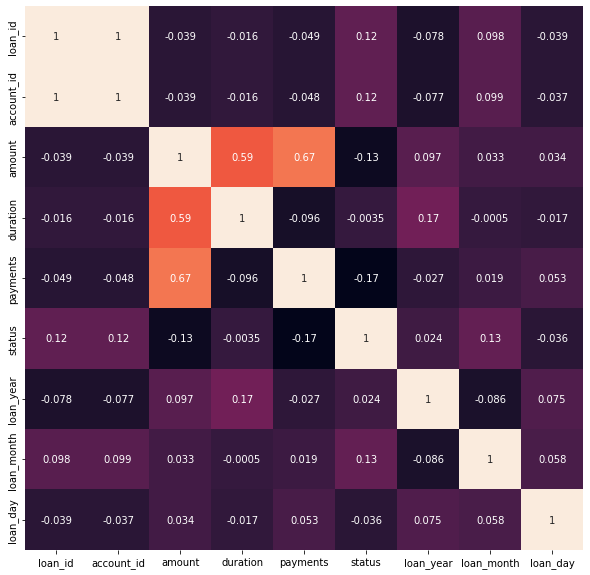

In [5]:
plt.figure(figsize=(10, 10))
sns.heatmap(loans.corr(), annot=True, cbar=False)

As we can see the duration, amount and payments variables are related, as expected, because everything goes right with the loan payment, they should be create a formula with the interest rate.
The status is inversely proportional to the payments and amount attributes, it also makes sense, as the larger the loan, the harder to pay it.
The coeficients of the other pairs of attributes do not show any big relationships between them.

### Distributions

So let's analyse the distribution of the other attributes.

<AxesSubplot:xlabel='amount', ylabel='Count'>

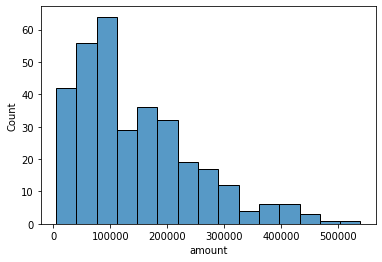

In [6]:
sns.histplot(data=loans, x='amount')

<AxesSubplot:xlabel='duration', ylabel='Count'>

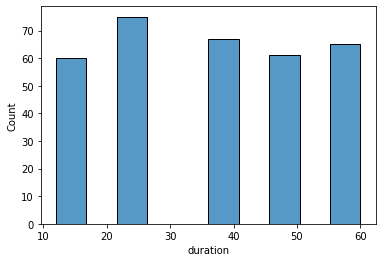

In [7]:
sns.histplot(data=loans, x='duration')

<AxesSubplot:xlabel='payments', ylabel='Count'>

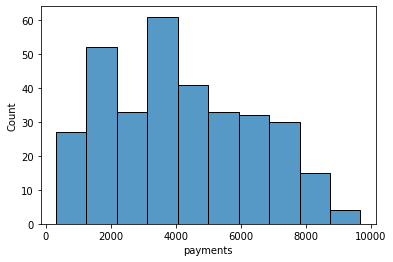

In [8]:
sns.histplot(data=loans, x='payments')